In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [54]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [55]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData

In [56]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [57]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)


In [58]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [59]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [60]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect the Database

In [26]:
from sqlalchemy import inspect
inspector = inspect(engine)


In [27]:
inspector.get_table_names()

['measurement', 'station']

In [28]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [29]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [67]:
# Find the most recent date in the dataset.
from datetime import datetime, timedelta

# dt_mostrecent = session.query(func.max(Measurement.date)).scalar()
dt_mostrecentstr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dt_mostrecentstr

('2017-08-23',)

In [ ]:
# Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data.
dt_mostrecent = dt.datetime.strptime(dt_mostrecentstr[0], '%Y-%m-%d')
qrydate = dt.date(dt_mostrecent.year -1, dt_mostrecent.month, dt_mostrecent.day)

In [ ]:
# Select only the "date" and "prcp" values.
sel = [Measurement.date,Measurement.prcp]
qryresult = session.query(*sel).filter(Measurement.date >= qrydate).all()


In [72]:
# Load the query results into a Pandas DataFrame. Explicitly set the column names.
qryresult_df = pd.DataFrame(qryresult,columns=['Date','Precipitation'])
qryresult_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [81]:
# Sort the DataFrame values by "date".
qryresult_sorted = qryresult_df.dropna(how='any')
qryresult_sorted = qryresult_sorted.sort_values(['Date'])
qryresult_sorted = qryresult_sorted.set_index('Date')
qryresult_sorted.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


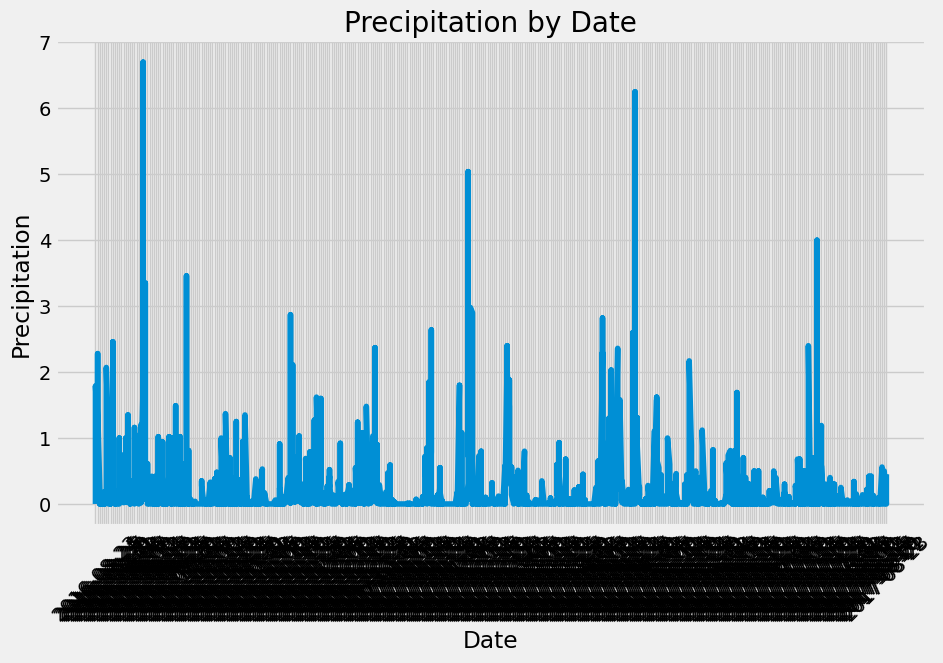

In [84]:
# Plot the results by using the DataFrame plot method, as the following image shows:
plt.figure(figsize=(10, 6))

# Create the line plot
# plt.plot(qryresult_sorted['Date'], qryresult_sorted['Precipitation'])
plt.plot(qryresult_sorted)

# Set the x-axis label and rotate the tick labels
plt.xlabel('Date')
plt.xticks(rotation=45)

# Set the y-axis label
plt.ylabel('Precipitation')

# Set the plot title
plt.title('Precipitation by Date')

# Display the plot
plt.show()

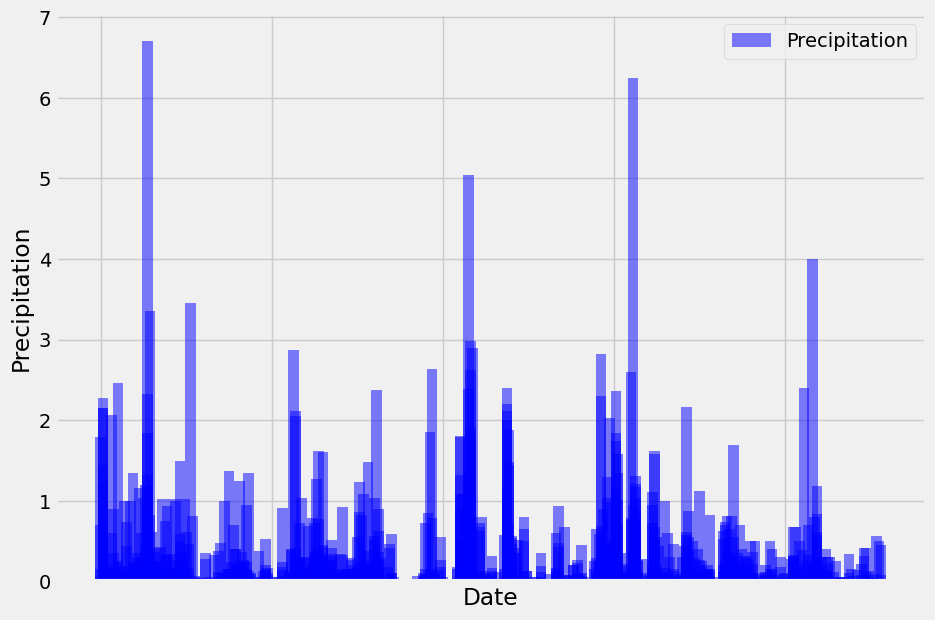

In [85]:
# Use Pandas Plotting with Matplotlib to plot the data

xx = qryresult_sorted.index.tolist()
yy = qryresult_sorted['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

# plt.title(f"Precipitation from {qrydate} to {lateststr[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [86]:
# Use Pandas to print the summary statistics for the precipitation data.
qryresult_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Old - use as reference

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = datetime.strptime(dt_mostrecent, '%Y-%m-%d')
one_year = last_date + timedelta(days=365)

print("One year from last date:", one_year.strftime('%Y-%m-%d'))

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).all()

for date, prcp in results:
    print(f"Date: {date}, Precipitation: {prcp}")


In [ ]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = session.query(Measurement.date.label('Date'), Measurement.prcp.label('Precipitation')).all()
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.head()

In [ ]:
# Sort the dataframe by date
sorted_df = df.sort_values('Date')
sorted_df.head()

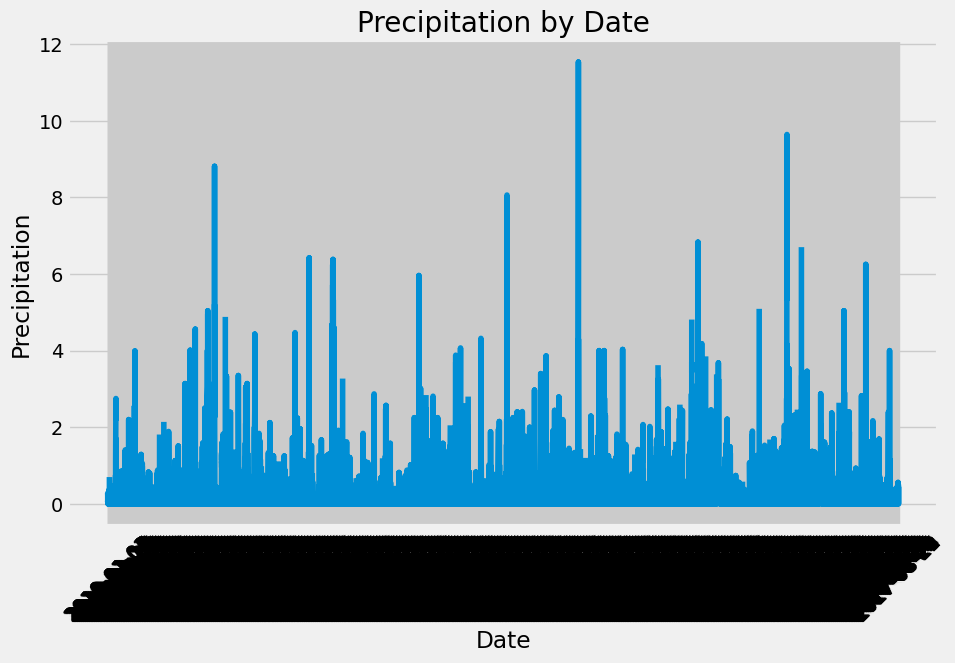

In [50]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))

# Create the line plot
plt.plot(sorted_df['Date'], sorted_df['Precipitation'])

# Set the x-axis label and rotate the tick labels
plt.xlabel('Date')
plt.xticks(rotation=45)

# Set the y-axis label
plt.ylabel('Precipitation')

# Set the plot title
plt.title('Precipitation by Date')

# Display the plot
plt.show()

In [42]:
session.close()

# Exploratory Station Analysis